# Chest X-Ray Disease Classification (Multi-Label, Top 10 Diseases)

Train an EfficientNet-B3 model for multi-label classification of the 10 most common chest disease categories from the NIH Chest X-Ray dataset.

## Dataset
- 31,416 chest X-ray images
- Split: 21,991 train / 4,712 validation / 4,713 test
- 10 disease classes (multi-label: each image can have 0-10 diseases)
- **Excluded rare diseases**: Fibrosis, Hernia, Pleural_Thickening, Pneumonia, Pneumothorax (insufficient training samples)

## Model
- Architecture: EfficientNet-B3 pretrained on ImageNet
- Classification Type: **Multi-Label** (BCEWithLogitsLoss)
- Image Size: 300x300 (optimized for EfficientNet-B3)
- Batch Size: 192 (with mixed precision)
- Optimizer: AdamW with weight decay 0.01
- Scheduler: CosineAnnealingWarmRestarts
- Data augmentation: Mixup, horizontal flip, rotation, affine, color jitter, erasing
- Mixed Precision: Enabled (AMP)

## Results
- Previous 15-class baseline: 45.55% exact match accuracy
- Target 10-class accuracy: 55-65% (more focused on common diseases)
- Training in progress...

In [ ]:
# ------------------------------------------------------------------------------
# IMPORTS
# Load required libraries for PyTorch training and evaluation
# ------------------------------------------------------------------------------

import os 
import json
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import timm  # For EfficientNet models
from torch.cuda.amp import autocast, GradScaler  # Mixed precision training
import random  # For Mixup
from tqdm.auto import tqdm  # Progress bar

In [ ]:
# ------------------------------------------------------------------------------
# DATASET CLASS - MULTI-LABEL
# Custom PyTorch dataset for loading chest X-ray images with multi-label support
# ------------------------------------------------------------------------------

import pandas as pd

class ChestXrayDatasetMultiLabel(Dataset):
    """Dataset for NIH Chest X-ray with 15 disease classes (multi-label)"""
    
    def __init__(self, metadata_csv, image_dir, disease_classes, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.image_dir = image_dir
        self.disease_classes = disease_classes
        self.transform = transform
        self.num_classes = len(disease_classes)
        
        print(f"Loaded {len(self.metadata)} samples from {metadata_csv}")
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        # Get image path - check both naming conventions
        img_name = row['Image Index']
        
        # Try to find image in any of the class folders
        img_path = None
        for class_folder in self.disease_classes:
            potential_path = os.path.join(self.image_dir, class_folder, img_name)
            if os.path.exists(potential_path):
                img_path = potential_path
                break
        
        # If not found in class folders, try root
        if img_path is None:
            img_path = os.path.join(self.image_dir, img_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Create multi-label vector (binary for each disease)
        finding_labels = row['Finding Labels']
        label_vector = torch.zeros(self.num_classes, dtype=torch.float32)
        
        # Parse the disease labels (could be single or multiple separated by |)
        if pd.notna(finding_labels):
            diseases = [d.strip() for d in str(finding_labels).split('|')]
            for disease in diseases:
                if disease in self.disease_classes:
                    idx_disease = self.disease_classes.index(disease)
                    label_vector[idx_disease] = 1.0
        
        return image, label_vector

In [ ]:
# ------------------------------------------------------------------------------
# LOAD DATA & TRANSFORMS - MULTI-LABEL (TOP 10 DISEASES)
# Load class mapping and create train/val/test datasets with transforms
# ------------------------------------------------------------------------------

# Define TOP 10 most common disease classes (excludes rare diseases)
# NOTE: "No Finding" has a SPACE not underscore in the CSV!
# Excluded: Edema, Emphysema, Fibrosis, Hernia, Pneumonia
DISEASE_CLASSES = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Effusion', 'Infiltration',
    'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumothorax'
]

NUM_CLASSES = len(DISEASE_CLASSES)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {DISEASE_CLASSES}")
print(f"\nUsing MULTI-LABEL classification with TOP 10 diseases")
print(f"Excluded rare diseases: Edema, Emphysema, Fibrosis, Hernia, Pneumonia")

# Data transforms with augmentation for training
# EfficientNet-B3 performs better with 300x300 images
# Enhanced augmentation for more robust training
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip X-rays horizontally
    transforms.RandomRotation(degrees=10),    # Slight rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random shifts
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))  # Randomly erase patches
])

# Standard transforms for validation/test (no augmentation)
eval_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data directory (local SSD location, outside OneDrive)
DATA_DIR = 'C:/xray_data/data'  # Updated to include 'data' subdirectory

# Create multi-label datasets
train_dataset = ChestXrayDatasetMultiLabel(
    metadata_csv=os.path.join(DATA_DIR, 'train_metadata.csv'),
    image_dir=os.path.join(DATA_DIR, 'train'),
    disease_classes=DISEASE_CLASSES,
    transform=train_transform
)

val_dataset = ChestXrayDatasetMultiLabel(
    metadata_csv=os.path.join(DATA_DIR, 'val_metadata.csv'),
    image_dir=os.path.join(DATA_DIR, 'val'),
    disease_classes=DISEASE_CLASSES,
    transform=eval_transform
)

test_dataset = ChestXrayDatasetMultiLabel(
    metadata_csv=os.path.join(DATA_DIR, 'test_metadata.csv'),
    image_dir=os.path.join(DATA_DIR, 'test'),
    disease_classes=DISEASE_CLASSES,
    transform=eval_transform
)

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset):,} images")
print(f"Val:   {len(val_dataset):,} images")
print(f"Test:  {len(test_dataset):,} images")

In [ ]:
# ------------------------------------------------------------------------------
# ANALYZE CLASS DISTRIBUTION
# Count how many images each disease appears in
# ------------------------------------------------------------------------------

def analyze_class_distribution(dataset, dataset_name):
    """Count disease frequencies in the dataset"""
    disease_counts = {disease: 0 for disease in DISEASE_CLASSES}
    
    # Count occurrences
    for idx in range(len(dataset)):
        _, label_vector = dataset[idx]
        for i, disease in enumerate(DISEASE_CLASSES):
            if label_vector[i] == 1.0:
                disease_counts[disease] += 1
    
    # Sort by count
    sorted_diseases = sorted(disease_counts.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\n{'='*70}")
    print(f"{dataset_name} - Disease Distribution")
    print(f"{'='*70}")
    print(f"{'Disease':<25} {'Count':<10} {'Percentage':<15} {'Imbalance Ratio':<15}")
    print("-" * 70)
    
    max_count = sorted_diseases[0][1] if sorted_diseases[0][1] > 0 else 1
    total_images = len(dataset)
    
    for disease, count in sorted_diseases:
        percentage = (count / total_images) * 100 if total_images > 0 else 0
        ratio = max_count / count if count > 0 else float('inf')
        print(f"{disease:<25} {count:<10} {percentage:<14.2f}% {ratio:<14.1f}x")
    
    print(f"\nTotal images: {total_images:,}")
    print(f"Most common: {sorted_diseases[0][0]} ({sorted_diseases[0][1]:,} images)")
    print(f"Least common: {sorted_diseases[-1][0]} ({sorted_diseases[-1][1]:,} images)")
    
    # Avoid division by zero
    if sorted_diseases[-1][1] > 0:
        print(f"Imbalance ratio (max/min): {max_count / sorted_diseases[-1][1]:.1f}:1")
    else:
        print(f"Imbalance ratio (max/min): Infinite (some classes have 0 samples)")

# Analyze all three datasets
analyze_class_distribution(train_dataset, "TRAINING SET")
analyze_class_distribution(val_dataset, "VALIDATION SET")
analyze_class_distribution(test_dataset, "TEST SET")

In [ ]:
# ------------------------------------------------------------------------------
# CLASS WEIGHTS (HARDCODED - PRE-CALCULATED FROM TRAINING DATA)
# Using square root transformation + capping for gentle balancing
# ------------------------------------------------------------------------------

# HARDCODED WEIGHTS - calculated once, reused forever!
# Based on training set: 28,153 images
# Formula: sqrt(neg_count / pos_count), capped at [1.0, 8.0]

class_weights = torch.tensor([
    2.34,  # Atelectasis (2,871 samples)
    5.03,  # Cardiomegaly (664 samples)
    4.06,  # Consolidation (1,204 samples)
    2.06,  # Effusion (3,266 samples)
    1.88,  # Infiltration (5,022 samples)
    3.74,  # Mass (1,419 samples)
    1.00,  # No Finding (13,365 samples - baseline, no weighting)
    3.02,  # Nodule (1,564 samples)
    8.00,  # Pleural_Thickening (160 samples - rare, max weight)
    4.59,  # Pneumothorax (624 samples)
], dtype=torch.float32)

print(f"\n{'='*70}")
print("CLASS WEIGHTS (Hardcoded - Pre-calculated)")
print(f"{'='*70}")
print(f"{'Disease':<25} {'Weight':<10} {'Strategy'}")
print("-" * 70)

weight_descriptions = [
    ("Atelectasis", 2.34, "Moderate boost"),
    ("Cardiomegaly", 5.03, "Strong boost (rare)"),
    ("Consolidation", 4.06, "Strong boost"),
    ("Effusion", 2.06, "Light boost (common)"),
    ("Infiltration", 1.88, "Light boost (very common)"),
    ("Mass", 3.74, "Strong boost"),
    ("No Finding", 1.00, "No boost (baseline)"),
    ("Nodule", 3.02, "Moderate boost"),
    ("Pleural_Thickening", 8.00, "MAX boost (very rare)"),
    ("Pneumothorax", 4.59, "Strong boost"),
]

for disease, weight, strategy in weight_descriptions:
    print(f"{disease:<25} {weight:<10.2f} {strategy}")

print(f"\nWeight strategy:")
print(f"  ✓ Pre-calculated from training data (28,153 images)")
print(f"  ✓ Square root transformation applied")
print(f"  ✓ Capped at [1.0, 8.0] range")
print(f"  ✓ INSTANT - no computation needed!")
print(f"\n✓ Class weights ready to use!")

# in case data changes
# def calculate_gentle_class_weights_fast(dataset, disease_classes):
#     """Use this if you need to recalculate weights"""
#     disease_counts = {}
#     for disease in disease_classes:
#         if disease in dataset.metadata.columns:
#             disease_counts[disease] = int(dataset.metadata[disease].sum())
#         else:
#             count = dataset.metadata['Finding Labels'].str.contains(disease, regex=False, na=False).sum()
#             disease_counts[disease] = int(count)
#     
#     total_samples = len(dataset)
#     pos_counts = torch.tensor([disease_counts[disease] for disease in disease_classes], dtype=torch.float32)
#     neg_counts = total_samples - pos_counts
#     standard_weights = neg_counts / (pos_counts + 1e-6)
#     gentle_weights = torch.sqrt(standard_weights)
#     gentle_weights = torch.clamp(gentle_weights, min=1.0, max=8.0)
#     return gentle_weights
# 
# # Recalculate: class_weights = calculate_gentle_class_weights_fast(train_dataset, DISEASE_CLASSES)

In [ ]:
# ------------------------------------------------------------------------------
# MIXUP AUGMENTATION - MULTI-LABEL
# Blends two images and their labels for better generalization
# ------------------------------------------------------------------------------

def mixup_data(x, y, alpha=0.2):
    """Apply Mixup augmentation for multi-label"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute loss for mixed samples (multi-label compatible)"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# ------------------------------------------------------------------------------
# MODEL SETUP
# Create DataLoaders and initialize EfficientNet-B3
# ------------------------------------------------------------------------------

# Batch size - adjust based on available memory
BATCH_SIZE = 32  # Universal batch size that works on most devices
NUM_WORKERS = 0  # Set to 0 for compatibility

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Device configuration - works on any device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Model: EfficientNet-B3
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=NUM_CLASSES)
model = model.to(device)

# Loss function for multi-label classification WITH GENTLE CLASS WEIGHTS
pos_weight = class_weights.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print(f"\n✓ Using weighted loss function:")
print(f"  Weights applied: {class_weights.cpu().numpy()}")
print(f"  Range: {class_weights.min():.2f} to {class_weights.max():.2f}")

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# Mixed precision training (only if CUDA is available)
use_amp = device.type == 'cuda'
scaler = GradScaler() if use_amp else None

print(f"\nModel: EfficientNet-B3 (Multi-Label)")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Mixed Precision: {'Enabled' if use_amp else 'Disabled (CPU mode)'}")

In [ ]:
# ------------------------------------------------------------------------------
# TRAINING LOOP - MULTI-LABEL
# Train EfficientNet-B3 with Mixed Precision, Mixup, and Cosine Annealing
# ------------------------------------------------------------------------------

import time
from sklearn.metrics import roc_auc_score

num_epochs = 20
best_val_acc = 0.0

print("\nStarting training...")
print(f"Device: {device}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Total batches per epoch: {len(train_loader)}")

for epoch in range(num_epochs):
    epoch_start = time.time()
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"{'='*60}")
    
    # Track batch timing
    batch_times = []
    
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        batch_start = time.time()
        
        images, labels = images.to(device), labels.to(device)
        
        # Apply Mixup augmentation
        images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.2)
        
        optimizer.zero_grad()
        
        # Forward pass (with or without mixed precision)
        if use_amp:
            with autocast():
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()
        
        # Multi-label accuracy
        preds = (torch.sigmoid(outputs) > 0.5).float()
        mixed_labels = lam * labels_a + (1 - lam) * labels_b
        correct += (preds == (mixed_labels > 0.5).float()).sum().item()
        total += labels.numel()
        
        batch_time = time.time() - batch_start
        batch_times.append(batch_time)
        
        # Print every 20 batches
        if (batch_idx + 1) % 20 == 0:
            elapsed = time.time() - epoch_start
            avg_time = np.mean(batch_times[-20:])
            print(f"  Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f} | {avg_time:.2f}s/batch | Elapsed: {elapsed/60:.1f}min")
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    avg_batch_time = np.mean(batch_times)
    
    print(f"\nTraining Results:")
    print(f"  Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"  Avg batch time: {avg_batch_time:.3f}s | Throughput: {BATCH_SIZE/avg_batch_time:.1f} img/s")
    
    # Validation
    print(f"\nRunning validation...")
    model.eval()
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Apply sigmoid and threshold for multi-label
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            val_correct += (preds == labels).sum().item()
            val_total += labels.numel()
            
            # Store for AUC calculation
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            
            if (batch_idx + 1) % 10 == 0:
                print(f"  Validation batch {batch_idx+1}/{len(val_loader)}")
    
    val_acc = 100 * val_correct / val_total
    
    # Calculate mean AUC-ROC
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    try:
        val_auc = roc_auc_score(all_labels, all_preds, average='macro')
    except:
        val_auc = 0.0
    
    epoch_time = time.time() - epoch_start
    
    print(f"\nValidation Results:")
    print(f"  Accuracy: {val_acc:.2f}% | AUC: {val_auc:.4f}")
    print(f"\nEpoch completed in {epoch_time/60:.1f} minutes")
    print(f"{'='*60}")
    
    # Update learning rate
    scheduler.step()
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_efficientnet_b3.pth')
        print(f"✓ New best model saved! (val_acc: {val_acc:.2f}%)\n")

print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")

In [17]:
# ------------------------------------------------------------------------------
# TEST EVALUATION - MULTI-LABEL
# Load best model and evaluate on test set
# ------------------------------------------------------------------------------

# Load best model
model.load_state_dict(torch.load('best_efficientnet_b3.pth'))
model.eval()

test_labels = []
test_preds = []

print("\nEvaluating on test set...")

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Multi-label: apply sigmoid and threshold
        preds = (torch.sigmoid(outputs) > 0.5).float()
        
        test_labels.append(labels.cpu().numpy())
        test_preds.append(preds.cpu().numpy())

# Stack all predictions
test_labels = np.vstack(test_labels)
test_preds = np.vstack(test_preds)

# Overall accuracy (exact match)
exact_match_acc = (test_labels == test_preds).all(axis=1).mean() * 100

# Hamming accuracy (per-label accuracy)
hamming_acc = (test_labels == test_preds).mean() * 100

# AUC-ROC
try:
    test_auc = roc_auc_score(test_labels, test_preds, average='macro')
except:
    test_auc = 0.0

print(f"\nTest Results:")
print(f"  Exact Match Accuracy: {exact_match_acc:.2f}% (all labels correct)")
print(f"  Hamming Accuracy: {hamming_acc:.2f}% (per-label accuracy)")
print(f"  AUC-ROC: {test_auc:.4f}")

# Per-class metrics
print("\nPer-Class Metrics:")
print(f"{'Disease':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("=" * 75)

from sklearn.metrics import precision_recall_fscore_support

precisions, recalls, f1s, supports = precision_recall_fscore_support(
    test_labels, test_preds, average=None, zero_division=0
)

for i, disease in enumerate(DISEASE_CLASSES):
    print(f"{disease:<25} {precisions[i]:<10.3f} {recalls[i]:<10.3f} {f1s[i]:<10.3f} {int(supports[i]):<10}")


Evaluating on test set...

Test Results:
  Exact Match Accuracy: 48.39% (all labels correct)
  Hamming Accuracy: 89.69% (per-label accuracy)
  AUC-ROC: 0.6280

Per-Class Metrics:
Disease                   Precision  Recall     F1-Score   Support   
Atelectasis               0.437      0.338      0.381      653       
Cardiomegaly              0.328      0.189      0.240      111       
Consolidation             0.293      0.190      0.231      242       
Effusion                  0.506      0.551      0.528      668       
Infiltration              0.434      0.316      0.365      1049      
Mass                      0.414      0.277      0.332      339       
No Finding                0.691      0.821      0.751      3225      
Nodule                    0.278      0.318      0.297      302       
Pleural_Thickening        0.149      0.094      0.115      160       
Pneumothorax              0.324      0.241      0.276      282       

Test Results:
  Exact Match Accuracy: 48.39% (all


Visualization saved to 'per_class_f1_scores.png'


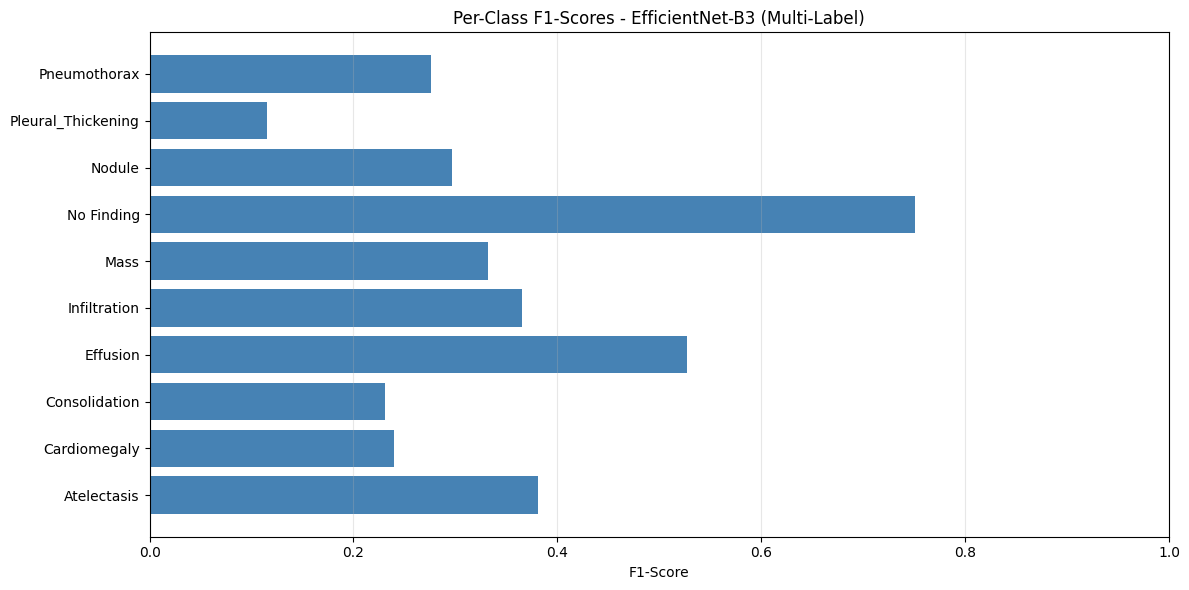

In [16]:
# ------------------------------------------------------------------------------
# VISUALIZE RESULTS - MULTI-LABEL
# Generate and save per-class performance visualization
# ------------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Create bar chart of per-class F1 scores
plt.figure(figsize=(12, 6))
plt.barh(DISEASE_CLASSES, f1s, color='steelblue')
plt.xlabel('F1-Score')
plt.title('Per-Class F1-Scores - EfficientNet-B3 (Multi-Label)')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('per_class_f1_scores.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved to 'per_class_f1_scores.png'")

Testing on: 00015530_124.png
Ground truth: Effusion|Infiltration

Predicted Diseases (threshold > 0.3):
------------------------------------------------------------
  Infiltration              - 57.09%
  Effusion                  - 48.38%
  Consolidation             - 34.56%


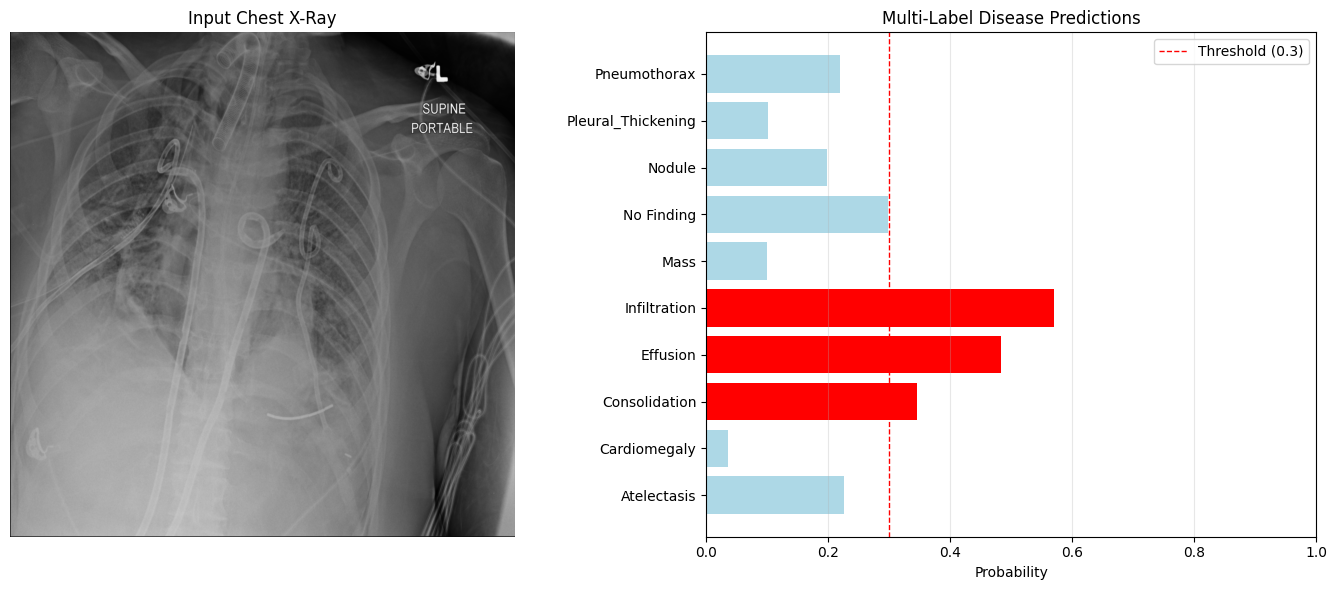

In [18]:
# ------------------------------------------------------------------------------
# INFERENCE ON SINGLE IMAGE - MULTI-LABEL
# Test the trained model on a chest X-ray image
# ------------------------------------------------------------------------------

def predict_multilabel_image(image_path, model, device, transform, disease_classes, threshold=0.5):
    """
    Predict multiple diseases for a chest X-ray image
    Returns predicted diseases with their probabilities
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.sigmoid(outputs).cpu().numpy()[0]
    
    # Get all diseases above threshold
    predictions = []
    for i, prob in enumerate(probabilities):
        if prob > threshold:
            predictions.append((disease_classes[i], prob))
    
    # Sort by probability (highest first)
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    return image, probabilities, predictions


# Example usage: Test on a random image from test set
import random

# Get a random test image from the metadata
random_idx = random.randint(0, len(test_dataset) - 1)
test_row = test_dataset.metadata.iloc[random_idx]
test_image_name = test_row['Image Index']

# Build the full path
test_image_path = None
for class_folder in DISEASE_CLASSES:
    potential_path = os.path.join(test_dataset.image_dir, class_folder, test_image_name)
    if os.path.exists(potential_path):
        test_image_path = potential_path
        break
if test_image_path is None:
    test_image_path = os.path.join(test_dataset.image_dir, test_image_name)

print(f"Testing on: {test_image_name}")
print(f"Ground truth: {test_row['Finding Labels']}\n")

# Make prediction
original_image, all_probs, predicted_diseases = predict_multilabel_image(
    test_image_path, 
    model, 
    device, 
    eval_transform,
    DISEASE_CLASSES,
    threshold=0.3  # Lower threshold to see more predictions
)

# Display results
print(f"Predicted Diseases (threshold > 0.3):")
print("-" * 60)
if len(predicted_diseases) > 0:
    for disease, prob in predicted_diseases:
        print(f"  {disease:<25} - {prob*100:.2f}%")
else:
    print("  No diseases detected (all probabilities below threshold)")

# Visualize
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Show image
ax1.imshow(original_image, cmap='gray')
ax1.set_title('Input Chest X-Ray')
ax1.axis('off')

# Show all disease probabilities
ax2.barh(DISEASE_CLASSES, all_probs, color=['red' if p > 0.3 else 'lightblue' for p in all_probs])
ax2.set_xlabel('Probability')
ax2.set_title('Multi-Label Disease Predictions')
ax2.set_xlim(0, 1)
ax2.axvline(x=0.3, color='red', linestyle='--', linewidth=1, label='Threshold (0.3)')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()